## Stochastic diffusion using mean-field limits to approximate master equations

*By L. Hébert-Dufresne, M. M. Kling, S. F. Rosenblatt, S. N.
Miller, P. A. Burnham, N. W. Landry, N. J. Gotelli, & B. J. McGill*

This notebook contains the pedagogical case studies used in the preprint "Stochastic diffusion with approximate master equations with mean-field limits".

N.B. This is a work in progress while the methods undergo peer review.

![](https://drive.google.com/uc?export=view&id=1hAWw4O3lCf6M0A5rJbvjkEHoWpsnNmXt)

# Birth-death process

We first write a classic master equation model. While the master equation applies for all values of active particles *n*, we write limiting cases for *n=0* and for some arbitrary large maximum *N*. That way, we can store the occupation number in a simple array of finite size and know that we will never try to look up the value of the array at *-1* or *N+1*.

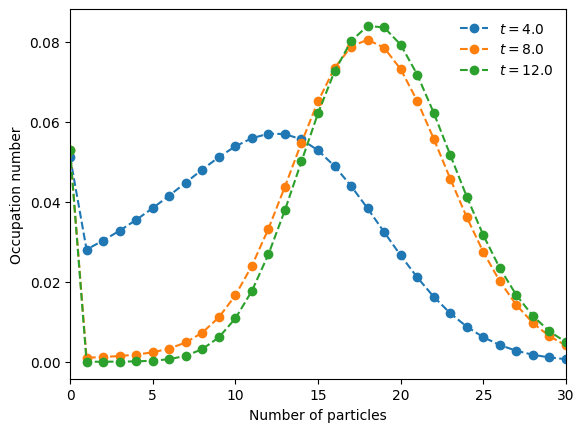

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We will use the odeint routine
from scipy.integrate import odeint


# Full master equation
def J(x, t, mu, nu):
    """
    Time derivative of the occupation numbers.
        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
    """
    dx = 0 * x
    for n in range(len(x)):
        if n == 0:  # for first state
            dx[0] = nu * x[1]
        elif n == len(x) - 1:  # for last state
            dx[n] = -(nu * n * n) * x[n] + mu * (n - 1) * x[n - 1]
        else:  # all other states
            dx[n] = (
                -(mu * n + nu * n * n) * x[n]
                + nu * (n + 1) * (n + 1) * x[n + 1]
                + mu * (n - 1) * x[n - 1]
            )

    return dx


# Time of observations
t_length = 12
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 100
x_0 = np.zeros(nb_of_states)
x_0[1] = 1

# Parameters
mu = 1.00
nu = 0.05

# Numerical integration
G = lambda x, t: J(x, t, mu, nu)
x_path = odeint(G, x_0, t_vec)

# Plot
for t in range(t_steps):
    if t > 0:
        plt.plot(
            range(nb_of_states),
            x_path[t],
            marker="o",
            ls="--",
            label=rf"$t = {t_vec[t]}$",
        )
plt.legend(frameon=False)
plt.ylabel("Occupation number")
plt.xlabel("Number of particles")
plt.xlim([0, 30])
plt.show()

We now write the mean-FLAME system for the same model. We use the exact same approach but we use a smaller *N* to leverage the computational efficiency of mean-flame and instead add two extra states for the occupation number and position of the mean-field limit that approximates all states beyond *N*.

(Extinction probability, mean-field limit position, mean-field limit occupation) =  (0.05129172428855688, 19.561950643742442, 0.7349945201850513)
(Extinction probability, mean-field limit position, mean-field limit occupation) =  (0.05292448412268085, 19.991800662018438, 0.9366723564277591)
(Extinction probability, mean-field limit position, mean-field limit occupation) =  (0.05298559229573842, 19.9998497693185, 0.9457326527244707)


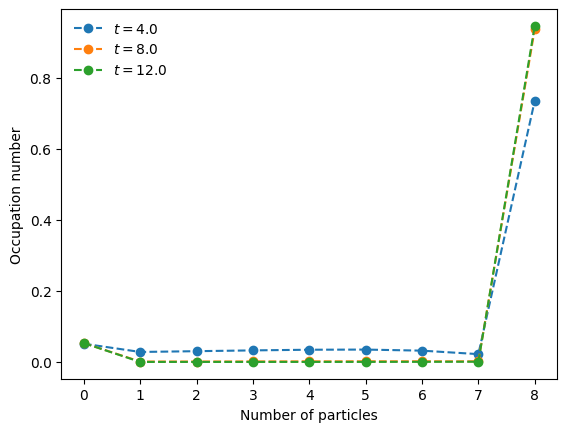

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We will use the odeint routine
from scipy.integrate import odeint

# and a Poisson approximation
from scipy.stats import poisson


# Master Equations
def meanFLAME(x, t, mu, nu):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
    """

    dx = 0 * x
    for n in range(len(x)):
        if n == 0:  # for first master equation state
            dx[0] = -mu * n * x[0] + nu * x[1]
        elif n == len(x) - 3:  # for last master equation state
            dx[n] = (
                -(nu * n * n) * x[n]
                + mu * (n - 1) * x[n - 1]
                - mu * n * x[n]
                + nu
                * (n + 1)
                * (n + 1)
                * poisson.pmf(n + 1, x[n + 2])
                * x[n + 1]
                / (1 - poisson.cdf(n, x[n + 2]))
            )
        elif n == len(x) - 2:  # for occupation number of the mean-field limit
            dx[n] = mu * (n - 1) * x[n - 1] - nu * n * n * poisson.pmf(n, x[n + 1]) * x[
                n
            ] / (1 - poisson.cdf(n - 1, x[n + 1]))
        elif n == len(x) - 1:  # for the position of the mean-field limit
            if x[n - 1] > 0:
                dx[n] = mu * x[n] - nu * x[n] * x[n]
            else:
                dx[n] = 0
        else:  # all other states
            dx[n] = (
                -(mu * n + nu * n * n) * x[n]
                + nu * (n + 1) * (n + 1) * x[n + 1]
                + mu * (n - 1) * x[n - 1]
            )

    return dx


# Time of observations
t_length = 12
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states_hybrid = 10
x_0 = np.zeros(nb_of_states_hybrid)
x_0[1] = 1
x_0[-1] = nb_of_states_hybrid - 1

# Parameters
mu = 1.00
nu = 0.05

# Integration
G = lambda x, t: meanFLAME(x, t, mu, nu)
y_path = odeint(G, x_0, t_vec)

# Plot
for t in range(t_steps):
    if t > 0:
        plt.plot(
            range(nb_of_states_hybrid - 1),
            y_path[t][0:-1],
            marker="o",
            ls="--",
            label=rf"$t = {t_vec[t]}$",
        )
        print(
            "(Extinction probability, mean-field limit position, mean-field limit occupation) = ",
            (y_path[t][0], y_path[t][-1], y_path[t][-2]),
        )
plt.legend(frameon=False)
plt.ylabel("Occupation number")
plt.xlabel("Number of particles")
plt.show()

We now compare the master equation and mean-FLAME approach by assuming some distribution (here a Poisson) around the mean-field limit.

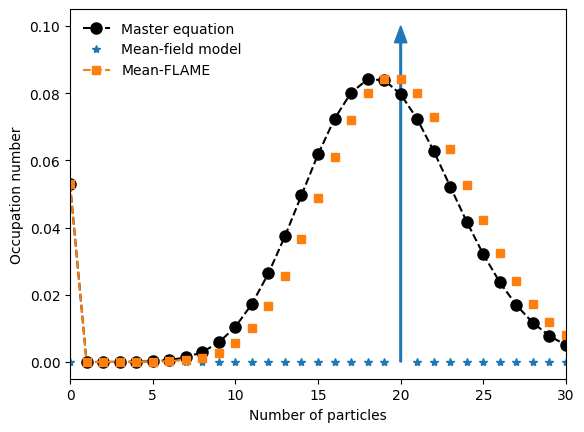

In [ ]:
# Comparison
kwargs = {"color": "tab:blue", "linestyle": "solid"}
plt.arrow(
    y_path[t_steps - 1][-1],
    0,
    0,
    0.095,
    width=0.1,
    head_width=0.75,
    head_length=0.005,
    **kwargs,
)
p = plt.plot(
    range(nb_of_states - 1),
    x_path[t_steps - 1][0:-1],
    marker="o",
    markersize=8,
    ls="--",
    color="black",
    label=rf"Master equation",
)
p = plt.plot(
    range(20),
    np.zeros(20),
    marker="*",
    color="tab:blue",
    linewidth=0,
    label=rf"Mean-field model",
)
p = plt.plot(
    range(21, 31), np.zeros(10), marker="*", color="tab:blue", linewidth=0, label=None
)
p = plt.plot(
    range(nb_of_states_hybrid - 2),
    y_path[t_steps - 1][0:-2],
    color="tab:orange",
    marker="s",
    ls="--",
    label=rf"Mean-FLAME",
)
for n in np.arange(nb_of_states_hybrid - 2, nb_of_states - 1):
    p = plt.plot(
        n,
        poisson.pmf(n, y_path[t_steps - 1][-1])
        * y_path[t_steps - 1][-2]
        / (1 - poisson.cdf(nb_of_states_hybrid - 3, y_path[t_steps - 1][-1])),
        marker="s",
        color=p[-1].get_color(),
        ls="None",
    )

plt.xlim([0, 30])
plt.legend(frameon=False)
plt.ylabel("Occupation number")
plt.xlabel("Number of particles")
plt.savefig("birth-death-res.pdf")

# Coupled birth-death processes

In [ ]:
# We use odeintw for integration of two-dimensional systems
!pip install odeintw

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# We will use the odeint routine
from scipy.integrate import odeint

# With a wrapper to facilitate 2d arrays
from odeintw import odeintw


# Master equation
@jit(nopython=True)
def J2(x, t, mu, nu, lamb):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
        * lamb is the coupling rate (linear lambda)
    """

    dx = 0 * x
    for n1, n2 in np.ndindex(x.shape):

        dx[n1, n2] = (
            -(mu * n1 + n2 * lamb + nu * n1 * n1) * x[n1, n2]
            - (mu * n2 + n1 * lamb + nu * n2 * n2) * x[n1, n2]
        )
        if n1 < x.shape[0] - 1:
            dx[n1, n2] += nu * (n1 + 1) * (n1 + 1) * x[n1 + 1, n2]
        if n1 > 0:
            dx[n1, n2] += (mu * (n1 - 1) + n2 * lamb) * x[n1 - 1, n2]
        if n2 < x.shape[1] - 1:
            dx[n1, n2] += nu * (n2 + 1) * (n2 + 1) * x[n1, n2 + 1]
        if n2 > 0:
            dx[n1, n2] += (mu * (n2 - 1) + n1 * lamb) * x[n1, n2 - 1]

    return dx


# Time of observations
t_length = 100
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 50
x_0 = np.zeros((nb_of_states, nb_of_states))
x_0[1, 1] = 1

# Parameters
mu = 1.00
nu = 0.1
lamb = 0.00

# Integration
G = lambda x, t: J2(x, t, mu, nu, lamb)
x_path = odeintw(G, x_0, t_vec)

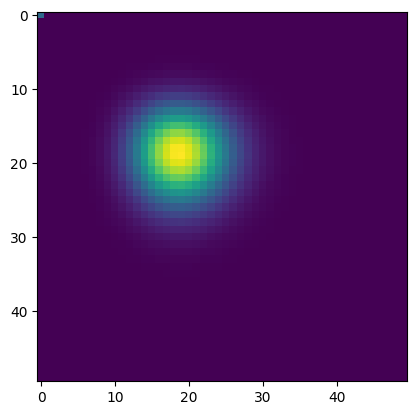

In [ ]:
# Visualization of the occupation numbers in 2d
plt.imshow(x_path[-1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We will use the odeint routine
from scipy.integrate import odeint

# and a Poisson approximation
from scipy.stats import poisson


# mean-FLAME
def meanFLAME2(x, t, mu, nu, lamb):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * mu is the birth rate (linear mu*n)
        * nu is the particle death rate (quadratic: nu*n*n)
        * lamb is the coupling rate (linear lambda)
    """

    dx = 0 * x

    theta = x[len(x) - 2] * x[len(x) - 1]
    for k in range(int(len(x) / 2), len(x) - 2):
        theta += (k - len(x) / 2) * x[k]
    theta = theta * lamb
    for n in range(int(len(x) / 2)):
        if n == 0:  # for first master equation state
            dx[0] = -(mu * n + theta) * x[0] + nu * x[1]
        elif n == int(len(x) / 2) - 3:  # for last master equation state
            dx[n] = (
                -(nu * n * n) * x[n]
                + (mu * (n - 1) + theta) * x[n - 1]
                - (mu * n + theta) * x[n]
                + nu
                * (n + 1)
                * (n + 1)
                * poisson.pmf(n + 1, x[n + 2])
                * x[n + 1]
                / (1 - poisson.cdf(n, x[n + 2]))
            )
        elif n == int(len(x) / 2) - 2:  # for occupation number of mean-field limit
            dx[n] = (mu * (n - 1) + theta) * x[n - 1] - nu * n * n * poisson.pmf(
                n, x[n + 1]
            ) * x[n] / (1 - poisson.cdf(n - 1, x[n + 1]))
        elif n == int(len(x) / 2) - 1:  # for the position of the mean-field limit
            if x[n - 1] > 0:
                dx[n] = (mu * x[n] + theta) - nu * x[n] * x[n]
            else:
                dx[n] = 0
        else:  # all other states
            dx[n] = (
                -(mu * n + theta + nu * n * n) * x[n]
                + nu * (n + 1) * (n + 1) * x[n + 1]
                + (mu * (n - 1) + theta) * x[n - 1]
            )

    theta = x[int(len(x) / 2) - 2] * x[int(len(x) / 2) - 1]
    for k in range(0, int(len(x) / 2) - 2):
        theta += k * x[k]
    theta = theta * lamb
    for k in range(int(len(x) / 2), len(x)):
        n = k - len(x) / 2
        if n == 0:  # for first master equation state
            dx[k] = -(mu * n + theta) * x[k] + nu * x[k + 1]
        elif k == len(x) - 3:  # for last master equation state
            dx[k] = (
                -(nu * n * n) * x[k]
                + (mu * (n - 1) + theta) * x[k - 1]
                - (mu * n + theta) * x[k]
                + nu
                * (n + 1)
                * (n + 1)
                * poisson.pmf(n + 1, x[k + 2])
                * x[k + 1]
                / (1 - poisson.cdf(n, x[k + 2]))
            )
        elif k == len(x) - 2:  # for occupation number of mean-field limit
            dx[k] = (mu * (n - 1) + theta) * x[k - 1] - nu * n * n * poisson.pmf(
                n, x[k + 1]
            ) * x[k] / (1 - poisson.cdf(n - 1, x[k + 1]))
        elif k == len(x) - 1:  # for the position of the mean-field limit
            if x[k - 1] > 0:
                dx[k] = (mu * x[k] + theta) - nu * x[k] * x[k]
            else:
                dx[k] = 0
        else:  # all other states
            dx[k] = (
                -(mu * n + theta + nu * n * n) * x[k]
                + nu * (n + 1) * (n + 1) * x[k + 1]
                + (mu * (n - 1) + theta) * x[k - 1]
            )

    return dx


# Time of observations
t_length = 100
t_steps = 4
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states_hybrid = 10
x_0 = np.zeros(2 * nb_of_states_hybrid)
x_0[1] = 1
x_0[nb_of_states_hybrid - 1] = nb_of_states_hybrid - 1
x_0[nb_of_states_hybrid] = 1
x_0[-1] = nb_of_states_hybrid - 1

# Parameters
mu = 1.00
nu = 0.1
lamb = 0.00

# Integration
G = lambda x, t: meanFLAME2(x, t, mu, nu, lamb)
y_path = odeint(G, x_0, t_vec)

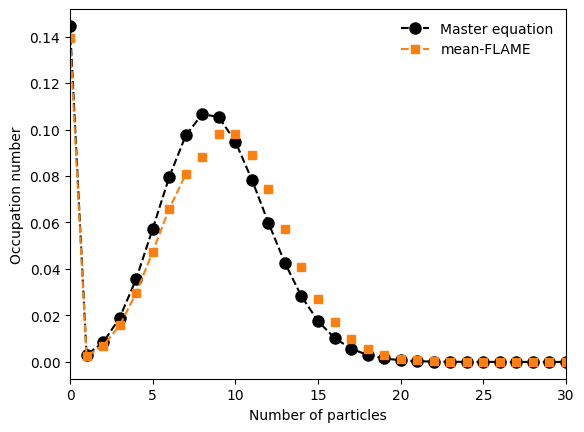

In [ ]:
# Comparison
p = plt.plot(
    range(nb_of_states),
    x_path[t_steps - 1].sum(axis=1),
    marker="o",
    markersize=8,
    ls="--",
    color="black",
    label=rf"Master equation",
)
p = plt.plot(
    range(nb_of_states_hybrid - 2),
    y_path[t_steps - 1][0:8],
    color="tab:orange",
    marker="s",
    ls="--",
    label=rf"mean-FLAME",
)
for n in np.arange(nb_of_states_hybrid - 2, nb_of_states - 1):
    p = plt.plot(
        n,
        poisson.pmf(n, y_path[t_steps - 1][9])
        * y_path[t_steps - 1][8]
        / (1 - poisson.cdf(nb_of_states_hybrid - 3, y_path[t_steps - 1][9])),
        marker="s",
        color=p[-1].get_color(),
        ls="None",
    )

plt.xlim([0, 30])
plt.legend(frameon=False)
plt.ylabel("Occupation number")
plt.xlabel("Number of particles")
plt.savefig("birth-death-res2.pdf")

# Lotka-Volterra dynamics

In [ ]:
# We use odeintw for integration of two-dimensional systems
!pip install odeintw

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# We will use the odeint routine
from scipy.integrate import odeint

# With a wrapper to facilitate 2d arrays
from odeintw import odeintw


# Master equation with just-in-time compiler to help integration of large system
@jit(nopython=True)
def J(x, t, alpha, gamma, beta):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * alpha is the prey birth rate
        * gamma is the predator death rate
        * beta is the predation rate
        * NB: We use logistic growth for preys to limit the # of states
        * K will be the carrying capacity
    """

    K = 20.0

    dx = 0 * x
    for n1, n2 in np.ndindex(x.shape):
        dx[n1, n2] -= gamma * n2 * x[n1, n2]  # predator death output
        if n1 < x.shape[0] - 1:  # prey birth output
            dx[n1, n2] -= alpha * n1 * (K - n1) * x[n1, n2] / K
        if n2 < x.shape[1] - 1:  # predation output
            dx[n1, n2] -= beta * n1 * n2 * x[n1, n2]
        if n1 > 0:  # prey birth input
            dx[n1, n2] += alpha * (n1 - 1) * (K - n1 + 1) * x[n1 - 1, n2] / K
        if n2 < x.shape[1] - 1:  # predator death input
            dx[n1, n2] += gamma * (n2 + 1) * x[n1, n2 + 1]
        if n1 < x.shape[0] - 1 and n2 > 0:  # predation input
            dx[n1, n2] += beta * (n1 + 1) * (n2 - 1) * x[n1 + 1, n2 - 1]

    return dx


# Time of observations
t_length = 100
t_steps = 101
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 25
x_0 = np.zeros((nb_of_states, nb_of_states))
x_0[12, 8] = 1

# Parameters
alpha = 0.9
gamma = 0.4
beta = 0.04

# Integration
G = lambda x, t: J(x, t, alpha, gamma, beta)
x_path = odeintw(G, x_0, t_vec)

In [ ]:
# Visualization as a gif
%matplotlib notebook
import numpy as np
import random
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML


# Plot
fig, ax = plt.subplots(figsize=(6, 6))
im = plt.imshow(np.log10(x_path[0]), vmin=-10, vmax=0.0)
cbar = plt.colorbar(im)
plt.ylabel("Number of prey")
plt.xlabel("Number of predator")
cbar.set_label("log10(Occupation)")


# animation function
def animate(i):
    res = np.log10(x_path[i])
    im.set_array(res)
    return [im]


# animation detailslog10
fps = 30
anim = FuncAnimation(fig, animate, frames=len(x_path), interval=5000 / fps)
anim.save("lv.gif", dpi=90)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

<ipython-input-13-340a4b8edbe0>:16: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(x_path[0]), vmin=-10, vmax=0.0)
<ipython-input-13-340a4b8edbe0>:24: RuntimeWarning: divide by zero encountered in log10
  res = np.log10(x_path[i])
<ipython-input-13-340a4b8edbe0>:24: RuntimeWarning: divide by zero encountered in log10
  res = np.log10(x_path[i])
